In [1]:
# external imports for project
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.integrate import solve_ivp

# 1D Drone Controller

You are tasked with building a drone that can hover at any given altitude. For the specific use case, the drone must settle at 0.1m within 10 seconds.

This model will utilize two main components, a controller which takes inputs about the state of the system (altitude and velocity) in order to produce a control force (thrust from rotors), and the physics that drive the system. The system can be modeled by the block diagram shown:

<img src="feedback_loop.png" width="500"/>

The controller block represents the control system keeping the drone at altitude. The physics represents a model of the real world that the drone will interact with.

## Governing Physics

The drone is restricted to 1 dimension (only changing altitude). Because the drone only operating in the Z direction, the system can be modeled using Newton's equation:

> $\sum F = ma$

The only forces we consider are gravity and the control force produced by the control system via the rotors:

> $F_G + F_C = ma$  

## PD Controller Intro

For this system, a simple PD controller will be used to maintain the given altitude. PD stands for Proportional-Derivative meaning the system uses information about the system's state (altitude) and the derivative of the state (velocity). To generate a corrective force, two things must be considered:

* What force will the system need to generate at the target altitude
* How will the system modulate the control force as the system gets closer to the target altitude  

### 


## Drone Controller

Create your drone controller object below. It should take the following form:

![](drone_controller.png)

In [2]:
class DroneController:
    
    def __init__(self, target_altitude: float, Kp: float, Kd: float, mass: float) -> None:
        """
        This object acts as the controller for the drone. It uses
        information about its past states to generate a control force
        in order to find equilibrium at a given altitude.
        """
        
        # physical parameters for the system
        
        # altitude to hover at
        self.target_altitude = target_altitude # m
        
        # hover velocity should be zero
        self.hover_velocity = 0.0 # m/s
        
        # gravitational constant
        self.g = 9.81 # m/s2
        
        # mass of the system
        self.mass = mass # kg
        
        # gains for the system
        self.Kp = Kp
        self.Kd = Kd
        
    def control_force(self, altitude: float, velocity: float) -> float:
        """
        function control_force
        
        uses the current altitude and velocity to calculate a control force for the system
        ------------------------
        altitude: current altitude from physics model or sensor
        velocity: current velocity from physics model or sensor
        """
        
        # calculate altitude and velocity error
        altitude_error = self.target_altitude - altitude
        velocity_error = self.hover_velocity - velocity
        
        # multiply by gains and add equilibrium force 
        F = self.Kp * altitude_error + self.Kd * velocity_error + self.mass*self.g
        
        return F

## Physics Model

The physics object will take a much simpler form as it is only responsible for motion in the Z-axis. The physics object should take the following form:

![](physics.png)

In [3]:
class Physics:
    
    def __init__(self, system_mass: float) -> None:
        """
        This object mimics the real world physics that act 
        on the system. Since it only has one dimensional
        motion, a 1D example of Newton's equations are 
        used.
        """
        # mass of the system
        self.mass = system_mass
        # gravitational constant
        self.g = 9.81
    
    def acceleration(self, input_forces: List[float]) -> float:
        """
        function acceleration:
        
        return the acceleration on the system
        ----------------------
        input_forces: list external forces on the system (control force)
        """
        a = (1 / self.mass) * (sum(input_forces) + self.mass * -self.g)
        return a

## Simulation Wrapper Solution

In [4]:
class Simulator:
    
    def __init__(self, system_mass: float, target_altitude: float, Kp: float, Kd: float):
        """
        This simulator uses both objects defined above. It steps the
        system through time and keeps track of system states.
        """
        
        self._model = Physics(system_mass)
        self._controller = DroneController(target_altitude, Kp, Kd, system_mass)
        self._acceleration = None
        
    
    def run_sim(self, time_window: List[float], time_step: float, 
                initial_velocity: float, initial_position: float) -> object:
        """
        function run_sim:
        
        propogates the sim through the provided time window
        ------------------
        time_window: List of length 2. 0 index is start time and 1 index is finish time
        
        time_step: The size of the time step evaluated
        
        initial_velocity: Starting velocity of drone m/s
        
        initial position: Starting position of drone m
        """
        
        self._control_force = []
        self._acceleration = []
        self._velocity = [initial_velocity]
        self._position = [initial_position]
        
        # create an array for the times/time steps
        steps = int((time_window[-1] - time_window[0]) / time_step)
        self._time = np.linspace(time_window[0], time_window[-1], steps)
        
        for i, t in enumerate(self._time):
            control_force = self._controller.control_force(self._position[-1], self._velocity[-1])
            self._control_force.append(control_force)
            self._acceleration.append(self._model.acceleration([control_force]))

            if len(self._acceleration) > 1:
                delta_t = t - self._time[i-1]
                
                v = self.integrator(self._acceleration[-2], self._acceleration[-1], delta_t, self._velocity[-1])
                self._velocity.append(v)
                
                p = self.integrator(self._velocity[-2], self._velocity[-1], delta_t, self._position[-1])
                self._position.append(p)
                
        return self

    def integrator(self, a, b, delta_t, previous_state):
        """
        function integrator:
        
        Uses the area of a trapeziod to integrate. This is added to 
        the previous state of the system and returned. 
        -----------------------
        a: Value at first time step
        
        b: Value at second time step
        
        delta_t: Size of time step
        
        previous_state: Previous state to be summed with the next integrated value
        
        """
        
        return ((a+b) * delta_t / 2) + previous_state
    
    def get_sim_results(self):
        
        """
        
        """
        
        if self._acceleration:
            return np.array([self._time, self._position, self._velocity, self._acceleration,
                            self._control_force]).transpose()
        else:
            raise Exception("Sim has not been run")
    
    def plot_results(self):
        
        if self._acceleration:
            
            sim_results = self.get_sim_results()
            time = sim_results[:, 0]
            position = sim_results[:, 1]
            velocity = sim_results[:, 2]
            acceleration = sim_results[:, 3]
            force = sim_results[:, 4]
            
            fig, axs = plt.subplot_mosaic([
                ["force","force","force"],
                ["position","velocity","acceleration"]])
            
            # plot control force
            axs["force"].plot(time, force)
            axs["force"].set_title("Control Force (N)")
            axs["force"].set_xlabel("Time (s)")
            axs["force"].set_ylabel("Thrust (N)")
            
            # plot drone position
            axs["position"].plot(time, position)
            axs["position"].set_title("Drone Altitude", fontsize = 9)
            axs["position"].set_xlabel("Time (s)")
            axs["position"].set_ylabel("altitude (m)")
            
            # plot drone velocity
            axs["velocity"].plot(time, velocity)
            axs["velocity"].set_title("Drone Velocity", fontsize = 9)
            axs["velocity"].set_xlabel("Time (s)")
            axs["velocity"].set_ylabel("velocity (m/s)")
            
            # plot drone acceleration
            axs["acceleration"].plot(time, acceleration)
            axs["acceleration"].set_title("Drone Acceleration", fontsize = 9)
            axs["acceleration"].set_xlabel("Time (s)")
            axs["acceleration"].set_ylabel("acceleration (m/s2)")
            
            fig.subplots_adjust(wspace = 0.8, hspace = 0.6)

### Results

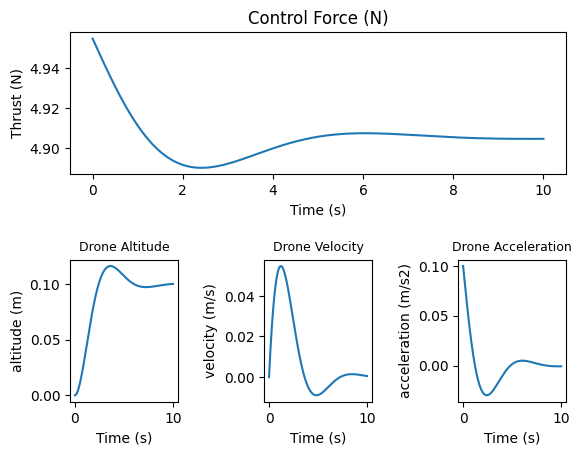

In [5]:
# plotting results

# sim setup
drone_mass = 0.5 # kg
target_altitude = 0.1 # m
Kp = 0.5
Kd = 0.5

# run sim params
time_window = [0.0,10] # s
time_step = 0.001 # s
z0 = 0.0 # m
dz0 = 0.0 # m/s

sim_results = Simulator(drone_mass, target_altitude, Kp, Kd)

sim_results.run_sim(time_window, time_step, z0, dz0).plot_results()

# ODE solver approach

Re-write $F = ma$ as $a = \frac{ddz}{ddt} = \frac{F}{m}$  

In [6]:
model = Physics(0.5)
controller = DroneController(0.1,0.5,0.5,0.5)
controller_forces = []

def state_propogator(t, state):
    
    z = state[0]
    dz = state[1]
    
    control_force = controller.control_force(z, dz)
    
    ddz = model.acceleration([control_force])
    
    return [dz, ddz]

y = [0,0]
results = solve_ivp(fun=state_propogator, t_span=[0, 10], y0 = y, rtol=1e-8)

Text(0, 0.5, 'velocity (m/s)')

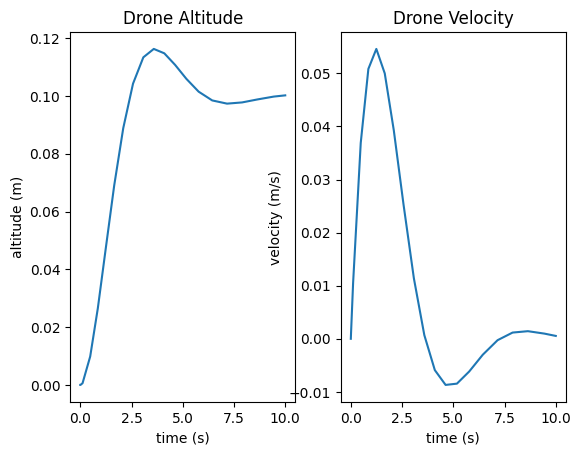

In [7]:
sol = results.y.T
fig, axs = plt.subplots(1,2)


axs[0].plot(results.t, sol[:,0])
axs[0].set_title("Drone Altitude")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("altitude (m)")

axs[1].plot(results.t, sol[:,1])
axs[1].set_title("Drone Velocity")
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("velocity (m/s)")